<h1 align=center>Stock Analysis</h1>

In [1]:
# from phi.agent import Agent
# from phi.model.openai import OpenAIChat
# from phi.tools.yfinance import YFinanceTools

# finance_agent = Agent(
#     name="Finance Agent",
#     model=OpenAIChat(id="gpt-4o"),
#     tools=[YFinanceTools(stock_price=True, analyst_recommendations=True, company_info=True, company_news=True)],
#     instructions=["Use tables to display data"],
#     show_tool_calls=True,
#     markdown=True,
# )
# finance_agent.print_response("Summarize analyst recommendations for NVDA", stream=True)

### Building an Agentic Financial Analyst with LangGraph and OpenAI

What this Agentic Financial Analyst will do?
- Fetches stock price data using Yahoo Finance.
- Calculates technical indicators like RSI, MACD, VWAP, and more.
- Evaluate financial metrics such as P/E ratio, Debt-to-Equity, and Profit Margins.
- Provides a structured, AI-generated analysis using OpenAI’s powerful language models.
`Tools We’ll Use`
- LangGraph: A library for orchestrating tools and building conversational agents.
- OpenAI GPT-4: For generating intelligent and structured financial insights.
- yfinance: To retrieve stock prices and financial ratios.
- ta (Technical Analysis Library): For calculating key technical indicators.
- Python libraries: pandas, dotenv, and datetime for data manipulation and environment setup.

#### Step 1: Setting Up the Environment

#### Step 2: Tools for Analyst
Fetching Stock Prices: This tool fetches the stock’s historical data and computes several technical indicators.

In [1]:
from typing import Union, Dict, Set, List, TypedDict, Annotated
import pandas as pd
from langchain_core.tools import tool
import yfinance as yf
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.volume import volume_weighted_average_price
import datetime as dt

@tool
def get_stock_prices(ticker: str) -> Union[Dict, str]:
    """Fetches historical stock price data and technical indicator for a given ticker."""
    try:
        data = yf.download(
            ticker,
            start=dt.datetime.now() - dt.timedelta(weeks=24*3),
            end=dt.datetime.now(),
            interval='1wk'
        )
        df= data.copy()
        data.reset_index(inplace=True)
        data.Date = data.Date.astype(str)
        
        indicators = {}
        
        rsi_series = RSIIndicator(df['Close'], window=14).rsi().iloc[-12:]
        indicators["RSI"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in rsi_series.dropna().to_dict().items()}
        
        sto_series = StochasticOscillator(
            df['High'], df['Low'], df['Close'], window=14).stoch().iloc[-12:]
        indicators["Stochastic_Oscillator"] = {
                    date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in sto_series.dropna().to_dict().items()}

        macd = MACD(df['Close'])
        macd_series = macd.macd().iloc[-12:]
        indicators["MACD"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in macd_series.to_dict().items()}
        
        macd_signal_series = macd.macd_signal().iloc[-12:]
        indicators["MACD_Signal"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in macd_signal_series.to_dict().items()}
        
        vwap_series = volume_weighted_average_price(
            high=df['High'], low=df['Low'], close=df['Close'], 
            volume=df['Volume'],
        ).iloc[-12:]
        indicators["vwap"] = {date.strftime('%Y-%m-%d'): int(value) 
                    for date, value in vwap_series.to_dict().items()}
        
        return {'stock_price': data.to_dict(orient='records'),
                'indicators': indicators}

    except Exception as e:
        return f"Error fetching price data: {str(e)}"

In [1]:
### updated
import datetime as dt
from typing import Union, Dict
import pandas as pd
from langchain_core.tools import tool
import yfinance as yf
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD
from ta.volume import volume_weighted_average_price

@tool
def get_stock_prices(ticker: str) -> Union[Dict, str]:
    """Fetches historical stock price data and technical indicators for a given ticker."""
    try:
        data = yf.download(
            ticker,
            start=dt.datetime.now() - dt.timedelta(weeks=24*3),
            end=dt.datetime.now(),
            interval='1wk'
        )

        if data.empty:
            return f"No data found for ticker: {ticker}"

        data.reset_index(inplace=True)
        data['Date'] = data['Date'].astype(str)

        indicators = {}

        rsi_series = RSIIndicator(data['Close'], window=14).rsi().iloc[-12:]
        indicators["RSI"] = dict(zip(data['Date'].iloc[-12:], map(lambda x: round(x, 2), rsi_series)))

        sto_series = StochasticOscillator(data['High'], data['Low'], data['Close'], window=14).stoch().iloc[-12:]
        indicators["Stochastic_Oscillator"] = dict(zip(data['Date'].iloc[-12:], map(lambda x: round(x, 2), sto_series)))

        macd = MACD(data['Close'])
        macd_series = macd.macd().iloc[-12:]
        indicators["MACD"] = dict(zip(data['Date'].iloc[-12:], map(lambda x: round(x, 2), macd_series)))

        macd_signal_series = macd.macd_signal().iloc[-12:]
        indicators["MACD_Signal"] = dict(zip(data['Date'].iloc[-12:], map(lambda x: round(x, 2), macd_signal_series)))

        vwap_series = volume_weighted_average_price(
            high=data['High'], low=data['Low'], close=data['Close'], volume=data['Volume']
        ).iloc[-12:]
        indicators["vwap"] = dict(zip(data['Date'].iloc[-12:], map(lambda x: round(x, 2), vwap_series)))

        return {
            'stock_price': data.to_dict(orient='records'),
            'indicators': indicators
        }

    except Exception as e:
        return f"Error fetching price data: {str(e)}"

Financial Ratios: This tool retrieves key financial health ratios.

In [2]:
@tool
def get_financial_metrics(ticker: str) -> Union[Dict, str]:
    """Fetches key financial ratios for a given ticker."""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        return {
            'pe_ratio': info.get('forwardPE'),
            'price_to_book': info.get('priceToBook'),
            'debt_to_equity': info.get('debtToEquity'),
            'profit_margins': info.get('profitMargins')
        }
    except Exception as e:
        return f"Error fetching ratios: {str(e)}"

In [2]:
### updated
@tool
def get_financial_metrics(ticker: str) -> Union[Dict, str]:
    """Fetches key financial ratios for a given ticker."""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        if not info:
            return f"No financial data found for ticker: {ticker}"

        def safe_get(key: str) -> Union[float, str]:
            value = info.get(key)
            return round(value, 3) if isinstance(value, (int, float)) else "N/A"

        return {
            'pe_ratio': safe_get('forwardPE'),
            'price_to_book': safe_get('priceToBook'),
            'debt_to_equity': safe_get('debtToEquity'),
            'profit_margins': safe_get('profitMargins'),
            'return_on_equity': safe_get('returnOnEquity'),
            'return_on_assets': safe_get('returnOnAssets'),
            'current_ratio': safe_get('currentRatio'),
            'quick_ratio': safe_get('quickRatio'),
            'gross_margins': safe_get('grossMargins'),
            'operating_margins': safe_get('operatingMargins')
        }

    except Exception as e:
        return f"Error fetching ratios: {str(e)}"


#### Step 3: Building the LangGraph
LangGraph allows us to orchestrate tools and manage conversational logic efficiently.

1. Defining the Graph
We start by defining a StateGraph to manage the flow:

In [4]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    stock: str
    
graph_builder = StateGraph(State)

In [3]:
### updated
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph

class State(TypedDict):
    messages: Annotated[List, add_messages]
    stock: str
    
graph_builder = StateGraph(State)

2. Defining OpenAI and Binding Tools

We integrate the tools into LangGraph and create a feedback loop for analysis

In [4]:
# import dotenv
# dotenv.load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

tools = [get_stock_prices, get_financial_metrics]
llm_with_tool = llm.bind_tools(tools)

In [7]:
llm_with_tool.invoke("What’s the P/E ratio of AAPL?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kxvJ9fxR4vaFHTeIOUT2C8Ei', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'get_financial_metrics'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 88, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'id': 'chatcmpl-BLtWM75PvYU8e1UQMfKLMNdDWRgQP', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-079c8948-2a44-4ae0-8954-773731e7545c-0', tool_calls=[{'name': 'get_financial_metrics', 'args': {'ticker': 'AAPL'}, 'id': 'call_kxvJ9fxR4vaFHTeIOUT2C8Ei', 'type': 'tool_call'}], usage_metadata={'input_tokens': 88, 'output_tokens': 18, 'total_tokens': 106, 'input_token_details': {'audio': 0,

3. Analyst Node

The prompt ensures the AI understands its role and delivers structured output.

In [5]:
from langchain.schema import SystemMessage
from langgraph.graph import START, END



FUNDAMENTAL_ANALYST_PROMPT = """
You are a fundamental analyst specializing in evaluating company (whose symbol is {company}) performance based on stock prices, technical indicators, and financial metrics. Your task is to provide a comprehensive summary of the fundamental analysis for a given stock.

You have access to the following tools:
1. **get_stock_prices**: Retrieves the latest stock price, historical price data and technical Indicators like RSI, MACD, Drawdown and VWAP.
2. **get_financial_metrics**: Retrieves key financial metrics, such as revenue, earnings per share (EPS), price-to-earnings ratio (P/E), and debt-to-equity ratio.

### Your Task:
1. **Input Stock Symbol**: Use the provided stock symbol to query the tools and gather the relevant information.
2. **Analyze Data**: Evaluate the results from the tools and identify potential resistance, key trends, strengths, or concerns.
3. **Provide Summary**: Write a concise, well-structured summary that highlights:
    - Recent stock price movements, trends and potential resistance.
    - Key insights from technical indicators (e.g., whether the stock is overbought or oversold).
    - Financial health and performance based on financial metrics.

### Constraints:
- Use only the data provided by the tools.
- Avoid speculative language; focus on observable data and trends.
- If any tool fails to provide data, clearly state that in your summary.

### Output Format:
Respond in the following format:
"stock": "<Stock Symbol>",
"price_analysis": "<Detailed analysis of stock price trends>",
"technical_analysis": "<Detailed time series Analysis from ALL technical indicators>",
"financial_analysis": "<Detailed analysis from financial metrics>",
"final Summary": "<Full Conclusion based on the above analyses>"
"Asked Question Answer": "<Answer based on the details and analysis above>"

Ensure that your response is objective, concise, and actionable."""

def fundamental_analyst(state: State):
    messages = [
        SystemMessage(content=FUNDAMENTAL_ANALYST_PROMPT.format(company=state['stock'])),
    ]  + state['messages']
    return {
        'messages': llm_with_tool.invoke(messages)
    }

graph_builder.add_node('fundamental_analyst', fundamental_analyst)
graph_builder.add_edge(START, 'fundamental_analyst')

In [ ]:
### updated
from langchain.schema import SystemMessage
from langgraph.graph import START, END

FUNDAMENTAL_ANALYST_PROMPT = """
You are a professional fundamental analyst specializing in evaluating the financial health and investment potential of publicly traded companies. Your task is to analyze the performance of the company with the stock symbol: {company}.

You have access to the following tools:
1. **get_stock_prices**: Provides the latest stock price, historical price trends, and technical indicators such as RSI, MACD, Stochastic Oscillator, and VWAP.
2. **get_financial_metrics**: Returns essential financial ratios including price-to-earnings (P/E), price-to-book (P/B), debt-to-equity (D/E), profit margins, return on equity (ROE), and other key metrics.

---

### TASK OBJECTIVE:
Use the tools to gather relevant data, then deliver a structured and data-driven fundamental analysis of the stock. Your output should provide investors with clear, factual insights based solely on the available information.

---

### ANALYSIS GUIDELINES:

1. **Stock Price and Trend Analysis**:
   - Identify recent price movement patterns, trend directions (uptrend, downtrend, or sideways), and any apparent support or resistance levels.
   - Comment on volatility or unusual momentum if observable.

2. **Technical Indicator Evaluation**:
   - Analyze the latest RSI, MACD, MACD signal line, Stochastic Oscillator, and VWAP values.
   - Determine whether the stock appears to be overbought, oversold, or trending neutrally.
   - Mention any bullish or bearish signals indicated by crossovers or divergences.

3. **Financial Health Overview**:
   - Summarize key financial ratios: P/E, P/B, D/E, profit margins, and other available metrics.
   - Highlight the company's capital structure, profitability, and valuation positioning.
   - Identify strengths or red flags based on standard fundamental benchmarks.

4. **Final Conclusion**:
   - Objectively conclude whether the stock appears fundamentally strong, weak, or neutral.
   - Avoid speculation; base your conclusion only on the data provided by the tools.

5. **Question Response**:
   - Directly answer the user’s original question using evidence from your full analysis.

---

### OUTPUT FORMAT:
Respond with a valid JSON-style structure as follows:

{
  "stock": "<Stock Symbol>",
  "price_analysis": "<Your analysis of recent price trends and support/resistance levels>",
  "technical_analysis": "<Your evaluation of technical indicators and signals>",
  "financial_analysis": "<Summary of financial metrics and their implications>",
  "final_summary": "<Concise conclusion based on the above findings>",
  "asked_question_answer": "<Direct, evidence-based answer to the user's original question>"
}

---

### RULES:
- Rely strictly on tool outputs — do not fabricate data.
- Maintain an objective, professional tone.
- If any tool fails or data is missing, mention this explicitly in your analysis.
"""


def fundamental_analyst(state: State):
   # Sanitize the stock symbol to ensure there are no extra spaces or newlines
    stock_symbol = state.get('stock', '').strip()
    
    if not stock_symbol:
        return {'error': 'Stock symbol is missing or improperly formatted.'}
     
    messages = [
        SystemMessage(content=FUNDAMENTAL_ANALYST_PROMPT.format(company=stock_symbol)),
    ]  + (state.get('messages', []))
    
    return {
        'messages': llm_with_tool.invoke(messages)
    }
graph_builder.add_node('fundamental_analyst', fundamental_analyst)
graph_builder.add_edge(START, 'fundamental_analyst')
# graph_builder.add_edge('fundamental_analyst', END)



4. Adding tool to graph and compile

In [7]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition



graph_builder.add_node(ToolNode(tools))
graph_builder.add_conditional_edges('fundamental_analyst', tools_condition)
graph_builder.add_edge('tools', 'fundamental_analyst')

graph = graph_builder.compile()

In [6]:
### updated
from langgraph.prebuilt import ToolNode, tools_condition

# Add the tool node with a name
graph_builder.add_node("tools", ToolNode(tools))

# Add the conditional routing based on whether tools are needed
graph_builder.add_conditional_edges("fundamental_analyst", tools_condition)

# Connect tool output back to fundamental analysis
graph_builder.add_edge("tools", "fundamental_analyst")

# Ensure start and end points are defined
# graph_builder.add_edge(START, "fundamental_analyst")
# graph_builder.add_edge("fundamental_analyst", END)  # or loop again if more processing

# Compile the graph
graph = graph_builder.compile()


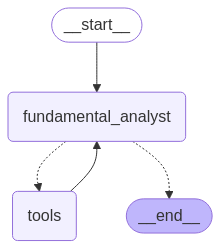

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

5. Executing the Graph

In [8]:
events = graph.stream({'messages':[('user', 'Should I buy this stock?')],
 'stock': 'NVIDIA Corp'}, stream_mode='values')
for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Should I buy this stock?
================================== Ai Message ==================================
Tool Calls:
  get_stock_prices (call_0SArDMyLHDIfDF5Qn1CydUzW)
 Call ID: call_0SArDMyLHDIfDF5Qn1CydUzW
  Args:
    ticker: NVDA
  get_financial_metrics (call_aXVfRSdtpdYqoSNWcaEtKulL)
 Call ID: call_aXVfRSdtpdYqoSNWcaEtKulL
  Args:
    ticker: NVDA
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


================================= Tool Message =================================
Name: get_financial_metrics

{"pe_ratio": 26.925, "price_to_book": 34.227, "debt_to_equity": 12.946, "profit_margins": 0.558, "return_on_equity": 1.192, "return_on_assets": 0.574, "current_ratio": 4.44, "quick_ratio": 3.672, "gross_margins": 0.75, "operating_margins": 0.611}
================================== Ai Message ==================================

"stock": "NVDA",
"price_analysis": "Unable to retrieve recent stock price movements and trends due to data fetching error. Therefore, assessment of potential resistance and key trends cannot be provided.",
"technical_analysis": "Technical indicators could not be retrieved due to data fetching error, thus analysis on overbought or oversold conditions is not available.",
"financial_analysis": "NVIDIA Corp's financial metrics indicate a P/E ratio of 26.925, suggesting a moderate valuation relative to earnings. The price-to-book ratio stands at 34.227, indica

In [8]:
events = graph.stream({'messages': [('user', 'Should I buy this stock?')], 'stock': 'NVIDIA Corp'}, stream_mode='values')

for event in events:
    if 'messages' in event:
        last_message = event['messages'][-1]
        
        # Ensure that the 'stock' key is correctly formatted
        stock_value = event.get('stock', '').strip()
        
        if stock_value:  # Check if stock symbol is valid
            print(f"Stock: {stock_value}")
        else:
            print("Stock symbol is missing or improperly formatted.")
        
        # Now handle the message part
        if hasattr(last_message, 'pretty_print'):
            last_message.pretty_print()
        else:
            print(last_message)


Stock: NVIDIA Corp
================================ Human Message =================================

Should I buy this stock?


KeyError: '\n  "stock"'

### 

2. ### 